In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay

In [6]:
def load_data(path):
    images = []
    labels = []
    curr_label = 0
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        if os.path.isdir(folder_path):  #and folder_name.startswith("Tomato"):
            print("Processing " + folder_path + ". Everything here will be labeled " + str(curr_label))
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if os.path.isfile(file_path):
                    try:
                        image = cv2.imread(file_path)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, (64, 64))
                        images.append(image)
                        labels.append(curr_label)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
            curr_label += 1

    images = np.array(images, dtype=np.float32)
    images /= 255.0
    images = torch.tensor(images, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

Processing dataset\Pepper__bell___Bacterial_spot. Everything here will be labeled 0
Processing dataset\Pepper__bell___healthy. Everything here will be labeled 1
Processing dataset\Potato___Early_blight. Everything here will be labeled 2
Processing dataset\Potato___healthy. Everything here will be labeled 3
Processing dataset\Potato___Late_blight. Everything here will be labeled 4
Processing dataset\Tomato_Bacterial_spot. Everything here will be labeled 5
Processing dataset\Tomato_Early_blight. Everything here will be labeled 6
Processing dataset\Tomato_healthy. Everything here will be labeled 7
Processing dataset\Tomato_Late_blight. Everything here will be labeled 8
Processing dataset\Tomato_Leaf_Mold. Everything here will be labeled 9
Processing dataset\Tomato_Septoria_leaf_spot. Everything here will be labeled 10
Processing dataset\Tomato_Spider_mites_Two_spotted_spider_mite. Everything here will be labeled 11
Processing dataset\Tomato__Target_Spot. Everything here will be labeled 12

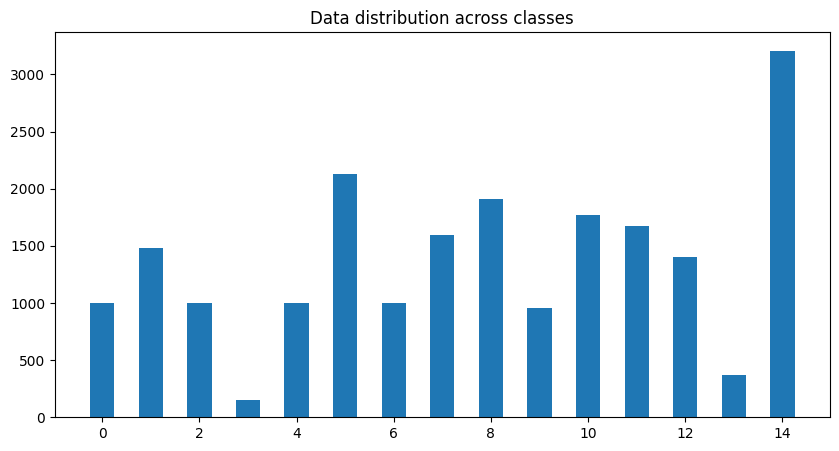

In [7]:
images, labels = load_data("dataset")
print(images.shape, labels.shape)

freq = np.bincount(labels)
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

plt.figure(figsize =(10, 5))
plt.title('Data distribution across classes')
plt.bar(classes, freq, width=0.5)
plt.show()

(15, 64, 64, 3)


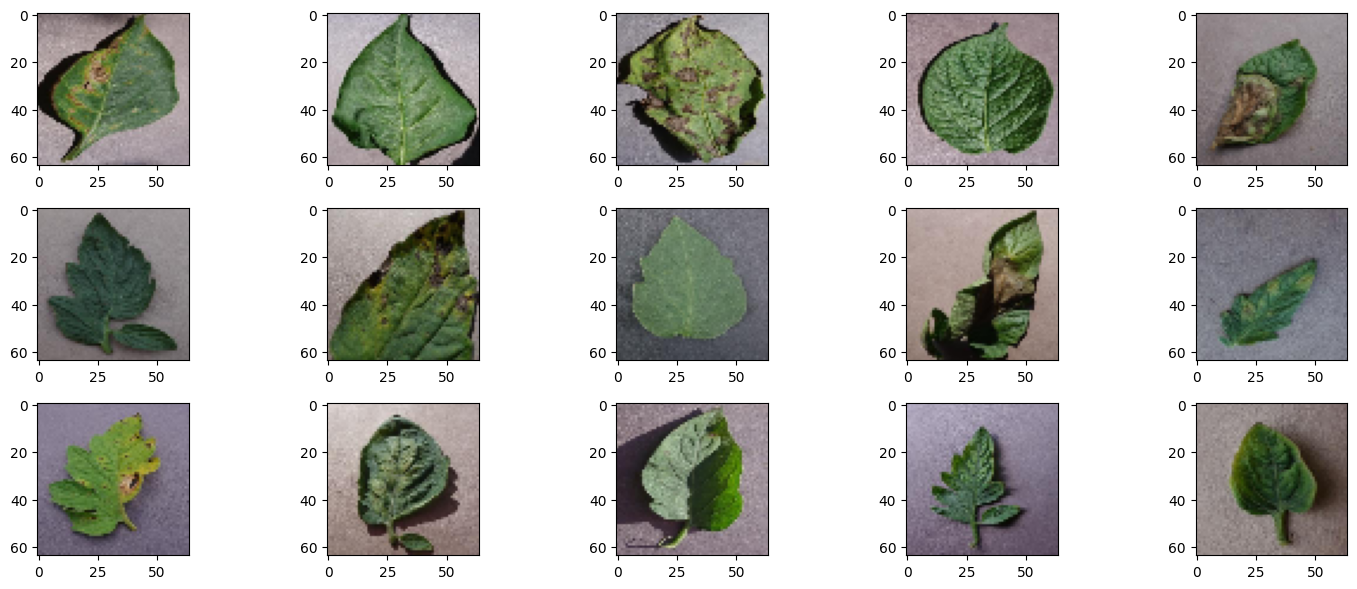

In [8]:
different_images = []
curr_label = 0
for i, image in enumerate(images):
    if labels[i] == curr_label:
        different_images.append(image)
        curr_label += 1
different_images = np.array(different_images)
print(different_images.shape)

fig, axes = plt.subplots(3, 5, figsize=(15, 6))

axes = axes.flatten()

for i in range(15):
    image = different_images[i]
    axes[i].imshow(image)

plt.tight_layout()
plt.show()

images = images.permute(0, 3, 1, 2)

torch.Size([16510, 3, 64, 64]) torch.Size([4128, 3, 64, 64])


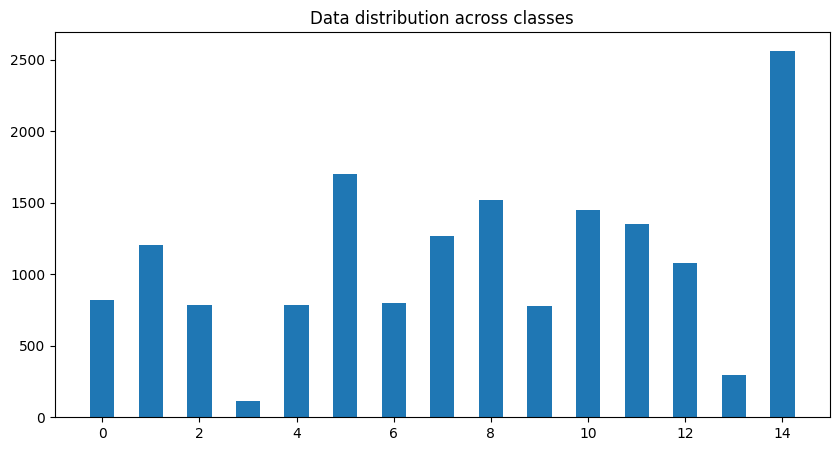

In [9]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# x_train = x_train.permute(0, 3, 1, 2)
# x_test = x_test.permute(0, 3, 1, 2)

print(x_train.shape, x_test.shape)

freq = np.bincount(y_train)
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

plt.figure(figsize =(10, 5))
plt.title('Data distribution across classes')
plt.bar(classes, freq, width=0.5)
plt.show()

In [10]:
class PlantDeseaseClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PlantDeseaseClassifier, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(input_dim, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 10),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 11 * 11, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.linear_stack(x)

    def fit(self, x_train, y_train, batch_size, criterion, optimizer, num_epochs):
        train_dataset = TensorDataset(x_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        train_losses = []
        epochs = np.arange(num_epochs)

        for epoch in range(num_epochs):
            epoch_loss = []

            for i, (images, labels) in enumerate(train_loader):
                images_pred = self.forward(images)
                loss = criterion(images_pred, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss.append(loss.item())

            epoch_loss = np.array(epoch_loss)
            train_losses.append(epoch_loss.mean())
            print(f"epoch {epoch + 1}/{num_epochs}, loss = {epoch_loss.mean()}")

        train_losses = np.array(train_losses)
        train_losses = np.array(train_losses)
        plt.plot(epochs, train_losses)
        plt.title("Loss function evolution during training")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()

    def evaluate(self, x_test, y_test):
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x_test).argmax(dim=1)

            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.show()

            print(classification_report(y_test, y_pred))

epoch 1/20, loss = 1.7341794991909072
epoch 2/20, loss = 0.9488089287350344
epoch 3/20, loss = 0.701012210386206
epoch 4/20, loss = 0.5834096837644429
epoch 5/20, loss = 0.4866824727072272
epoch 6/20, loss = 0.4322525640848533
epoch 7/20, loss = 0.3548784956133874
epoch 8/20, loss = 0.3086283014177583
epoch 9/20, loss = 0.2813624330731325
epoch 10/20, loss = 0.2209020626781754
epoch 11/20, loss = 0.2024572459049523
epoch 12/20, loss = 0.16897534880274545
epoch 13/20, loss = 0.14291563660426196
epoch 14/20, loss = 0.15812614387128676
epoch 15/20, loss = 0.11845019702842935
epoch 16/20, loss = 0.11713026987673902
epoch 17/20, loss = 0.0886842772128176
epoch 18/20, loss = 0.09162245301598351
epoch 19/20, loss = 0.09099314201040222
epoch 20/20, loss = 0.05989932522343295


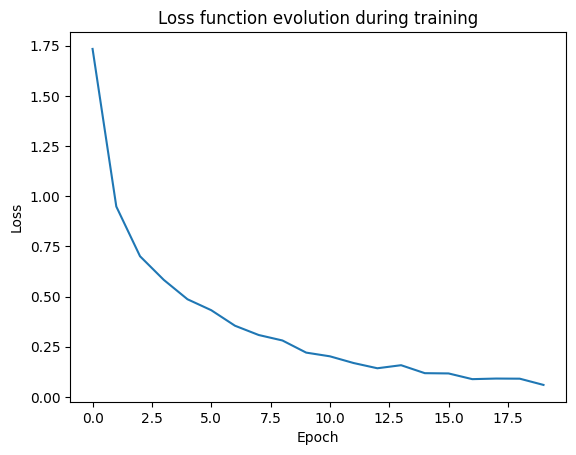

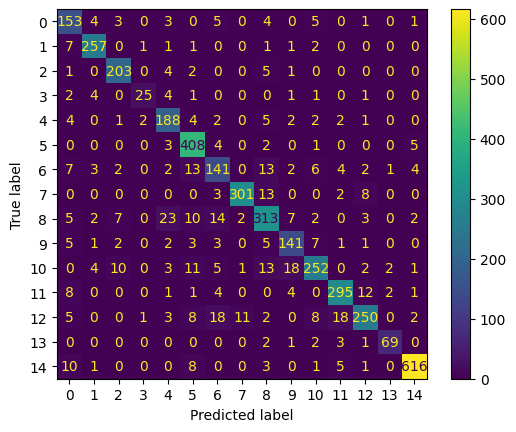

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       179
           1       0.93      0.95      0.94       271
           2       0.89      0.94      0.91       216
           3       0.86      0.64      0.74        39
           4       0.79      0.88      0.84       213
           5       0.87      0.96      0.91       423
           6       0.71      0.70      0.71       200
           7       0.96      0.92      0.94       327
           8       0.82      0.80      0.81       390
           9       0.79      0.82      0.81       171
          10       0.87      0.78      0.82       322
          11       0.89      0.90      0.90       328
          12       0.88      0.77      0.82       326
          13       0.93      0.88      0.91        78
          14       0.97      0.96      0.96       645

    accuracy                           0.88      4128
   macro avg       0.86      0.85      0.85      4128
weighted avg       0.88   

In [11]:
model = PlantDeseaseClassifier(3, 15)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

model.fit(x_train, y_train, 32, loss, optimizer, 20)
model.evaluate(x_test, y_test)